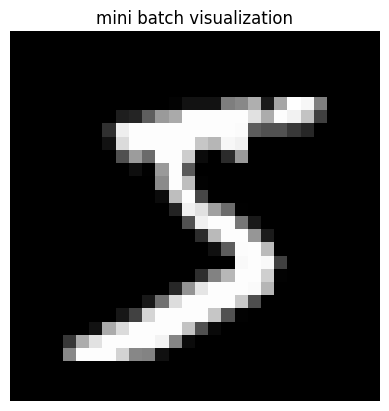

In [6]:
import torch
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt

# MNIST 데이터셋 (이미지 28x28)
dataset = datasets.MNIST(root="./data", train=True, download=True)
img, label = dataset[0]


plt.imshow(img, cmap="gray")
plt.title("mini batch visualization")
plt.axis('off')
plt.show()

## Resize : 고정된 크기로 이미지를 조정하는 기본 변환.
-  비율이 강제로 맞춰지므로 늘어나거나 찌그러질 수 있다.
-  입력 크기를 반드시 통일해야 하거나, 검증/테스트 시 재현성 유지가 필요할 때 사용
-  분류, 회귀, 탐지에서 공통적으로 사용

## 주요 인자
-  size : 원하는 출력 크기(정수 or (h, w) 튜플)

-  interpolation : 보간 방식 
1. NEAREST : 가장 가까운 픽셀 값 사용 (빠르지만 뭉개짐)
2. BILINEAR : 기본값, 부드럽게
3. BICUBIC : 고품질 
4. LANCZOS : 매우 고품질 (느림)

- max_size : 긴 쪽의 최대 크기 제한  / default : None
1. size 타입에 따라서 max_size 지정이 필요하다.

2. tuple(h, w)로 줄 때 -> 무조건 (height, width)로 강제 변환한다. 이 경우에는 비율이 깨져도 그냥 맞추는 거라 max_size는 필요 없다.

3. int로 줄 때 -> "짧은 변"을 size로 맞추고, 긴 변은 원래 비율을 유지하면서 자동 조정된다. 이떄 긴 변이 너무 커지면 문제가 생길 수 있어서 max_size로 제한한다. 

4. 짧은 변과 같은 비율로 줄여 자동 조정

- antialias : 이미지 축소 시 계단 현상 방지 / default : True

**계단 현상** : 이미지를 축소하거나 확대할 때 곡선이나 대각선 부분이 매끄럽게 표현되지 않고, 마치 계단처럼 꺾여 보이는 현상

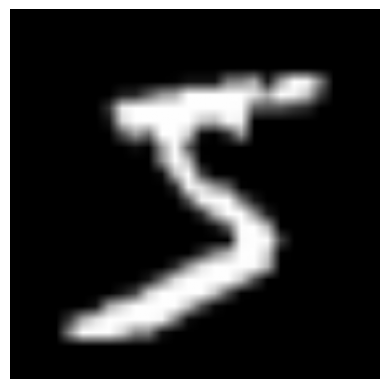

In [28]:
resize1 = v2.Resize(256)
out1 = resize1(img)

# 2) 정확히 224x224로 리사이즈
resize2 = v2.Resize((224,224))
out2 = resize2(img)

# 3) max_size 제한 걸기
resize3 = v2.Resize(300, max_size=400)
out3 = resize3(img)

# 4) 다양한 interpolation 비교
resize_nearest = v2.Resize((224,224), interpolation=v2.InterpolationMode.NEAREST)
resize_bicubic = v2.Resize((224,224), interpolation=v2.InterpolationMode.BICUBIC)

out_nearest = resize_nearest(img)
out_bicubic = resize_bicubic(img)

plt.imshow(out3, cmap="gray")
plt.axis('off')
plt.show()

## v2.ScaleJitter  
- 입력 이미지를 일정 크기로 resize하되, 그 안에서 크기를 랜덤하게 조정(zoom in/out) 하는 "대규모 지터" 기법
- 학습 중 모델이 다양한 크기 입력에 적응하도록 돕는 증강 도구
- 예시) v2.ScaleJitter(target_size,
                       scale_range=(0.5, 2.0),
                       interpolation=BILINEAR)

## 주요 인자
- target_size : 기준이 되는 출력 크기

- scale_range : 랜덤 스케일 범위(ex. 0.5 ~ 2.0 배 확대/축소) / default : (0.5 , 2.0)

- interpolation : 보간 방식 / 위 Resize 내용과 동일 / default : BILINEAR

- antialias : 이미지 축소 시 계단 현상 방지 / default : True

**jitter** : "흔들다, 변동을 주다" 라는 뜻 
1. 딥러닝에서 jittering 은 이미지의 크기, 색상, 위치 등을 약간 랜덤하게 변형해서 모델이 다양한 상황에 잘 적응하도록 만드는 데이터 증강 기법이다.

2. ColorJitter : 밝기 / 대비 / 채도 / 색조 를 랜덤하게 흔들어줌

3. ScaleJitter : 크기(스케일)를 랜덤하게 흔들어줌

4. Large Scale Jittering (대규모 지터) : 일반적인 RandomResizedCrop 같은 증강은 작은 범위에서 확대/축소를 랜덤하게 한다. 하지만 Large Scale Jittering은 훨씬 큰 범위를 허용해서, 아주 많이 확대(zoom-in), 아주 많이 축소(zoom-out)도 허용함. 즉 대규모 라는 건 스케일 변화를 크게 준다는 뜻 

5. 사용하는 이유 
-  일반환 성능 up : 모델이 다양한 크기의 물체를 보게 되어, 크기 변화에 강건해진다.
-  물체 탐지: 같은 태스크에서 특히 효과적 : 작은 물체, 큰 물체를 모두 학습시켜야 하기 때문

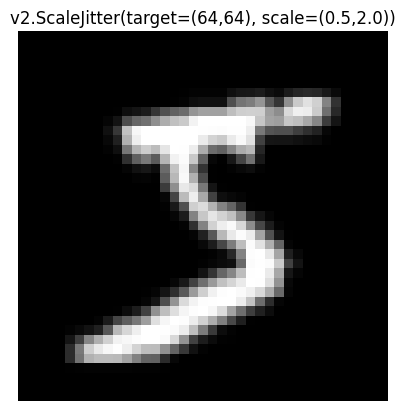

In [38]:
scale_jitter = v2.ScaleJitter(
    target_size=(64, 64),
    scale_range=(0.5, 2.0),        
    interpolation=v2.InterpolationMode.BILINEAR
)

scale_img = scale_jitter(img)

plt.imshow(scale_img, cmap="gray")
plt.title("v2.ScaleJitter(target=(64,64), scale=(0.5,2.0))")
plt.axis('off')
plt.show()

## RandomShortestSize 
- v2.RandomShortestSize(min_size,
                        max_size=None,
                        interpolation=InterpolationMode.BILINEAR,
                        antialias=True)
- 입력 이미지의 짧은 변(short side) 을 무작위로 설정하고, 비율은 유지한 채로 전체 크기를 맞춘다.
- min_size ~ max_size 사이에서 랜덤하게 resize (경량 증강)

## 주요 인자
- min_size : 짧은 변의 최소 크기

- max_size : 짧은 변의 최대 크기 (랜덤 크기 선택) / default : None

- interpolation : 보간 방식 / default : BILINEAR

- antialias : 이미지 축소 시 계단 현상 방지 / default : True

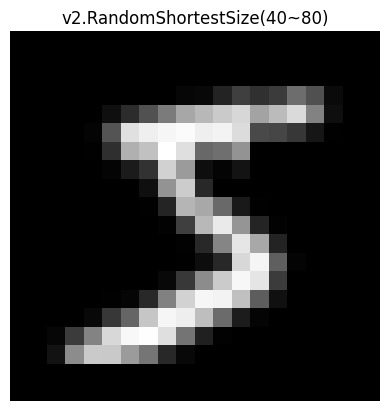

In [106]:
shortest_resize = v2.RandomShortestSize(min_size=20, max_size=80)
short_img = shortest_resize(img)

plt.imshow(short_img, cmap="gray")
plt.title("v2.RandomShortestSize(40~80)")
plt.axis('off')
plt.show()

## RandomResize :
- v2.RandomResize(min_size,
                  max_size,
                  interpolation=BILINEAR,
                  antialias=True)
- 전체 크기를 랜덤 값으로 바꿈

## 주요 인자
- min_size : 랜덤 최소 크기

- max_size : 랜덤 최대 크기

- interpolation : 보간 방식 / default : BILINEAR

- antialias : 이미지 축소 시 계단 현상 방지 / default : True

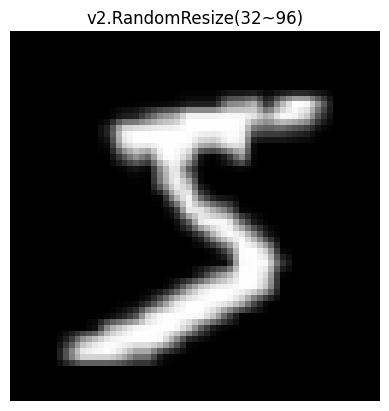

In [118]:
random_resize = v2.RandomResize(min_size=32, max_size=96)
random_img = random_resize(img)

plt.imshow(random_img, cmap="gray")
plt.title("v2.RandomResize(32~96)")
plt.axis("off")
plt.show()